# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

In this question, we want design a decoder/encoder structure for image captioning task.

In this question we use `Tasnin agancy news` dataset that you can download it from [[here]](https://www.kaggle.com/code/malekzadeharman/persian-image-captioning-dataset-sample-usage)


PIC model is designed with a three-part architecture, utilizing Convolutional Neural Networks (CNNs), Encoders and Decoders (Transformers):

1. CNN: The EfficientNetB0 model is employed as the initial layer to extract meaningful features from input images. The pre-trained weights from ImageNet are used, and the feature extractor is frozen during training.

2. Encoder: The extracted image features are passed through a Transformer-based encoder. This encoder enhances the representation of the inputs, incorporating self-attention mechanisms for better context understanding.

3. Decoder: This model takes the encoder output and text data (sequences) as inputs. It is trained to generate captions by utilizing self-attention and cross-attention mechanisms. The decoder incorporates positional embeddings for sequence information and employs dropout layers for regularization. Models: Utilize the latest advancements in deep learning for image captioning.

# 1. Setup

In [12]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08


### 1.1. set kaggle setting

In [13]:
!pip install kaggle
!chmod 600 data/kaggle.json

### 1.2. install essentioal libraray

In [14]:
!pip -q install hazm
!pip -q install arabic-reshaper
!pip install python-bidi

### 2. download dataset

In [ ]:
!kaggle datasets download -d malekzadeharman/persian-image-captioning-dataset -p /content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/data/

Dataset URL: https://www.kaggle.com/datasets/malekzadeharman/persian-image-captioning-dataset
License(s): CC-BY-SA-4.0
100% 1.65G/1.65G [00:32<00:00, 48.8MB/s]
100% 1.65G/1.65G [00:32<00:00, 54.6MB/s]


### 2.1. unzip dataset

In [ ]:
import zipfile
import os

zip_file_path = os.path.join("data/", "persian-image-captioning-dataset.zip")

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("data/")

KeyboardInterrupt: 

### 2.2. Import Libraries

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import hazm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from bidi.algorithm import get_display
import arabic_reshaper
import hazm
import json
import random
from bidi.algorithm import get_display

### 2.3. export images path

In [16]:
dataset_dir = "data/images/"

image_paths = []
for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

image_paths

['data/images/140008192158258324028333.jpg',
 'data/images/1400081921582588024028333.jpg',
 'data/images/1400081921582630224028333.jpg',
 'data/images/1400081921582641124028333.jpg',
 'data/images/1400081921582663024028333.jpg',
 'data/images/140008192158269824028333.jpg',
 'data/images/1400081921582716124028333.jpg',
 'data/images/1400081921582730224028333.jpg',
 'data/images/1400081921582744224028333.jpg',
 'data/images/1400081921582770824028333.jpg',
 'data/images/1400081921582789524028333.jpg',
 'data/images/140008192158280524028333.jpg',
 'data/images/1400081921582825524028333.jpg',
 'data/images/1400082010461338224029663.jpg',
 'data/images/1400082010461338224029664.jpg',
 'data/images/1400082010461347624029663.jpg',
 'data/images/1400082010461356924029663.jpg',
 'data/images/1400082010461366324029663.jpg',
 'data/images/1400082010461375724029663.jpg',
 'data/images/1400082010461383524029663.jpg',
 'data/images/1400082010461391324029663.jpg',
 'data/images/14000820104614163240296

### 2.4. visualize dataset

In [17]:
news_df = pd.read_json("data/" + "news.json", encoding='utf-8-sig')

print("data frame size: ", news_df.shape)
news_df

data frame size:  (1459, 6)


,title,description,reporter,time,category,images
0,غبارروبی مضجع شریف حضرت معصومه(س),مراسم خطبه خوانی و غبارروبی مضجع شریف حضرت مع...,آهویی - مریزاد,۰۹ آبان ۱۴۰۰ - ۱۷:۵۰,باشگاه خبرنگاران پویا,"[140008091737564223944594.jpg, 140008091737564..."
1,شورآباد,قالقاچی ، روستایی است از توابع بخش انزل در شه...,مجتبی اسماعیل زاده,۰۴ دی ۱۳۹۶ - ۱۰:۴۷,مستند,"[139603131324563911057744.jpg, 139603131324563..."
2,مشکلات زیست محیطی مالوجه - کردستان,مالوجه در بخش دلبران، با قریب به ۵هزار نفر جم...,کیوان فیروزه ای,۱۰ مهر ۱۴۰۰ - ۰۹:۲۲,استانها,"[1400030913402621922879884.jpg, 14000309134026..."
3,همایش علمای شیعه و سنی - گرگان,همایش علمای شیعه و سنی با موضوع سیره نبوی و م...,مصطفی حسن زاده,۲۵ مهر ۱۴۰۰ - ۱۳:۵۵,استانها,"[1400072513020612623840104.jpg, 14000725130206..."
4,افتتاح بیمارستان سریع الاحداث درمان اضطراری جم...,در جهت کمک به روند درمان و سرویس دهی به بیمار...,عبدالرحمن رافتی,۲۶ مرداد ۱۴۰۰ - ۱۴:۳۴,استانها,"[1400052613510297923408304.jpg, 14000526135102..."
...,...,...,...,...,...,...
1454,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1455,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1456,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1457,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."


### 2.5. Create a dictionary to store image paths with their titles

In [18]:
image_title_dict = {}

# Populate the dictionary with image paths and their corresponding titles
for index, row in news_df.iterrows():
    for image in row['images']:
        image_path = os.path.join(dataset_dir, image)
        if image_path in image_paths:
            image_title_dict[image_path] = row['title']

In [19]:
image_title_dict

{'data/images/140008091737564223944594.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/140008091737564223944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375771423944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375921423944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375944923944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375690223944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917380013623944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375726123944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375749523944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375737023944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917380068323944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375713623944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data

### 2.6. Function to reshape and display Farsi text

In [20]:
def reshape_text(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

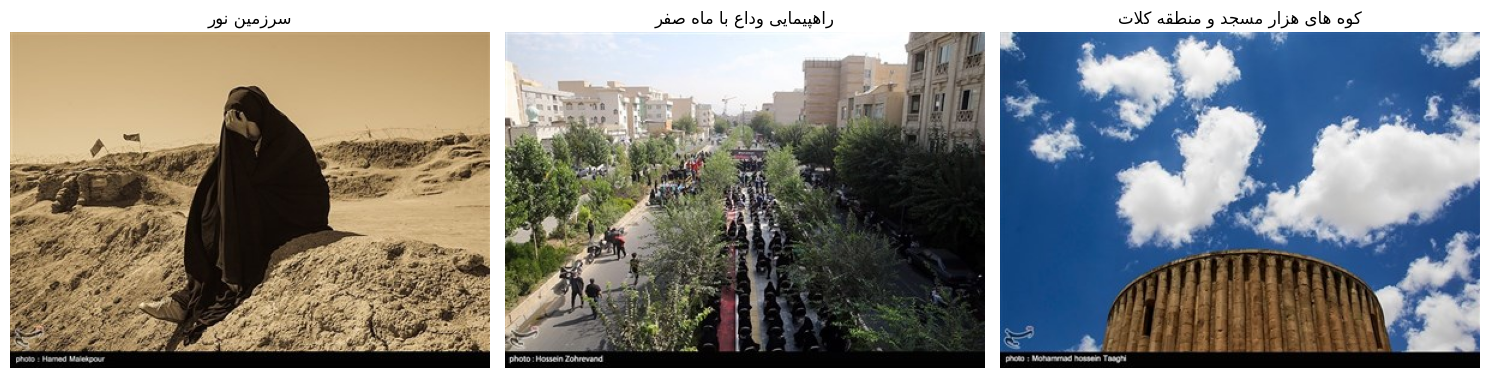

In [21]:
random_images = random.sample(list(image_title_dict.items()), 3)

# Plot the selected images with their captions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (image_path, title) in zip(axes, random_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(reshape_text(title), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
def plot_scatter_tokens(dataset):
    token_len = dataset['title'].apply(lambda cap:len(cap.split()))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(token_len, bins=30, color='green', edgecolor='white')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.subplot(132)
    plt.boxplot(token_len)
    plt.xlabel('Token Length')
    plt.ylabel('Lenght')
    plt.subplot(133)
    plt.plot(token_len)
    plt.xlabel('Tokens')
    plt.ylabel('Lenght')


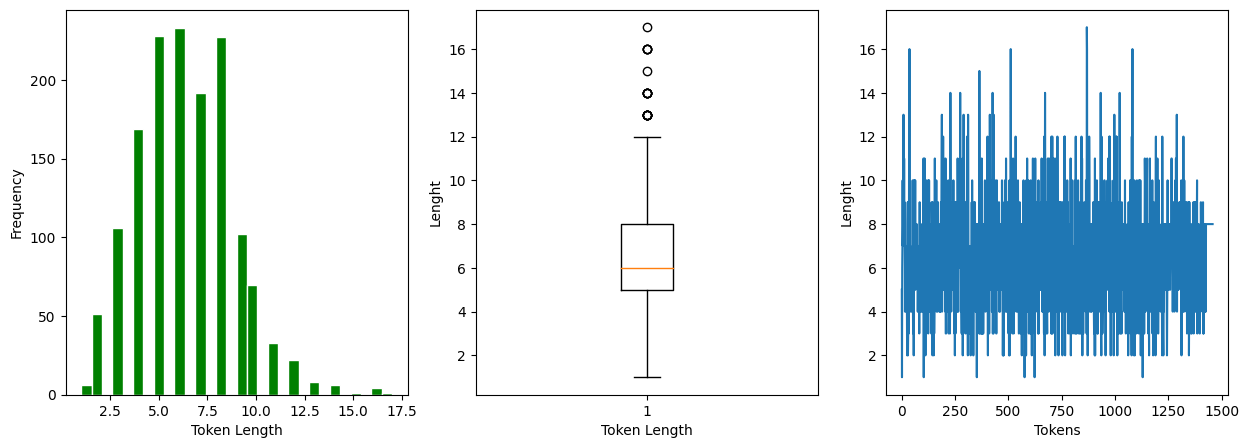

In [23]:
plot_scatter_tokens(news_df)

### 2.7. Calculate the number of tokens in each title

In [24]:
title_lengths = news_df['title'].apply(lambda x: len(x.split()))

# Find the maximum and minimum number of tokens
max_tokens = title_lengths.max()
min_tokens = title_lengths.min()

print("maximum token: ", max_tokens)
print("minimum token: ", min_tokens)

maximum token:  17
minimum token:  1


In [25]:
news_df.shape[0]

1459

In [26]:
def dataset_split(df, dataset_len=1459, min_token=1, max_token=17, train_size=0.8, test_size = 0.1, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    filterd_df = df[df['title'].apply(lambda cap: min_token <= len(cap.split()) <= max_token )][:dataset_len]
    print("total data: ", len(filterd_df))

    train_size = int(dataset_len * train_size)
    test_size = int(dataset_len * test_size)

    train_df, test_valid_df = train_test_split(filterd_df,test_size=0.2,random_state=42)
    test_df, valid_df = train_test_split(test_valid_df,test_size=0.5,random_state=42)


    return train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [27]:
train_df, valid_df, test_df = dataset_split(news_df, dataset_len=news_df.shape[0])
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
print("Number of test samples: ", len(test_df))

total data:  1459
Number of training samples:  1167
Number of validation samples:  146
Number of test samples:  146


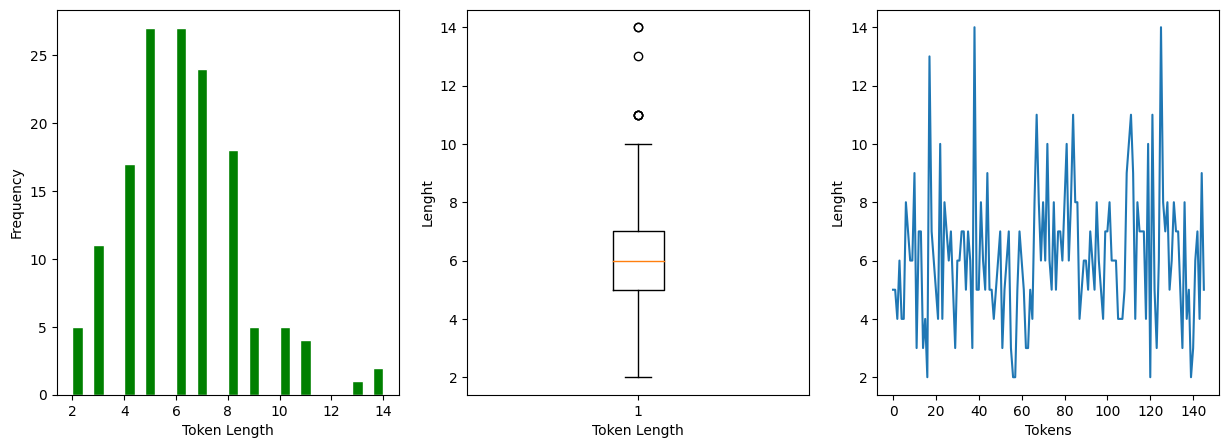

In [28]:
plot_scatter_tokens(test_df)

In [29]:
all_caption_data = news_df['title'].str.cat()
with open('data/all_captions.txt','w') as file:
    file.write(all_caption_data)

# 3. Word embedding

### 3.1. Vectorizing the text data

In [30]:
"""
## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).
"""

tokenizer = hazm.WordTokenizer()
persian_tokens = tokenizer.tokenize(all_caption_data)

print('all tokens len:', len(persian_tokens))
print('len unique tokens:', len(set(persian_tokens)))

VOCAB_SIZE = len(set(persian_tokens))
SEQ_LENGTH = 25

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
)

vectorization.adapt(persian_tokens)

all tokens len: 8404
len unique tokens: 3281


In [31]:
vocab = vectorization.get_vocabulary()
len(vocab)

3263

In [32]:
print(train_df['title'][0])
vectorization(train_df['title'][0])

بهشت نفت؛ جهنم غیزانیه


<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([2787,    1, 2567,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

### 3.2. Data augmentation for image data

In [33]:
image_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomContrast(0.3),
    ]
)

In [34]:
import cv2

_img = cv2.imread(dataset_dir + '1396121510150694313529973.jpg')
h, w, _ = _img.shape
print('width: ', w)
print('height:', h)

width:  400
height: 280


### 3.3. Flatten the DataFrame

In [36]:
IMAGE_SIZE = (w, h)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def flatten_dataframe(df, dataset_dir):
    flat_data = []
    for _, row in df.iterrows():
        for image in row['images']:
            image_path = os.path.join(dataset_dir, image)
            if os.path.exists(image_path):
                flat_data.append({'title': row['title'], 'image_path': image_path})
            else:
                print(f"Invalid path: {image_path}")
    return pd.DataFrame(flat_data)

# Adjust the TensorFlow Dataset Creation
def decode_image_and_vectorize(path, caption):
    img = tf.io.read_file(path)
    try:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
    except tf.errors.InvalidArgumentError:
        print(f"Error decoding image: {path}")
        img = tf.zeros((*IMAGE_SIZE, 3), dtype=tf.float32)
    vcaption = vectorization(caption)
    return img, vcaption

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((list(df['image_path']), list(df['title'])))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(decode_image_and_vectorize, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [37]:
train_df = flatten_dataframe(train_df, dataset_dir)
valid_df = flatten_dataframe(valid_df, dataset_dir)
test_df = flatten_dataframe(test_df, dataset_dir)

In [39]:
train_dataset = make_dataset(train_df)
valid_dataset = make_dataset(valid_df)
test_dataset = make_dataset(test_df)

In [41]:
batch = next(iter(train_dataset))
print(batch[0].shape)
print(batch[1].shape)

(64, 400, 280, 3)
(64, 25)


# 4. Define Model

### 4.1. design Transformer architecture

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)



class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, seq_len, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=embed_dim, sequence_length=seq_len, vocab_size=vocab_size
        )
        self.out = layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

### 4.2. Building the model

In [43]:
"""
## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.
"""

from keras import layers
from keras.applications import efficientnet


EPOCHS = 50
EMBED_DIM = 512
FF_DIM = 512

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2, seq_len=SEQ_LENGTH, vocab_size=VOCAB_SIZE)

16705208/16705208 [==============================] - 0s 0us/step


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=1,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        with tf.GradientTape() as tape:
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq, training=True
            )

            batch_loss += loss
            batch_acc += acc

            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            grads = tape.gradient(loss, train_vars)

            self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        img_embed = self.cnn_model(batch_img)

        loss, acc = self._compute_caption_loss_and_acc(
            img_embed, batch_seq, training=False
        )

        batch_loss += loss
        batch_acc += acc

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):

        return [self.loss_tracker, self.acc_tracker]

### 4.3. Building ImageCaptioningModel

In [45]:
"""
## Building ImageCaptioningModel
"""

caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [46]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
    def get_config(self):
      config = {
      # 'd_model': self.d_model
      'warmup_steps': self.warmup_steps,

      }
      return config


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# 5. Train phase

In [47]:
"""
Model training
"""
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/50
144/518 [=======>......................] - ETA: 40:17 - loss: 8.2339 - acc: 3.4529e-04

InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input is empty.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  Input is empty.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_15755]